# VGG-SSD EDA 
각 셀별로 실행 가능하며, 샘플 데이터셋을 이용한 EDA 수행

## 1️⃣ 라이브러리 임포트 및 설정

In [17]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
import json
import fnmatch
print('라이브러리 로딩 완료')

라이브러리 로딩 완료


## 2️⃣ 샘플 데이터셋 생성

In [3]:
# 실제 데이터셋 경로 지정
data_root = r'C:/Users/user/.vscode/pill-snap/data/ai04-level1-project'
train_images_dir = os.path.join(data_root, 'train_images')
train_annotations_dir = os.path.join(data_root, 'train_annotations')

In [4]:
# 어노테이션 파싱 및 category_id 매핑
category_ids = set()
for root, dirs, files in os.walk(train_annotations_dir):
    for ann_file in fnmatch.filter(files, '*.json'):
        ann_path = os.path.join(root, ann_file)
        try:
            with open(ann_path, 'r', encoding='utf-8') as f:
                ann_data = json.load(f)
            for ann in ann_data.get('annotations', []):
                category_ids.add(ann['category_id'])
        except Exception as e:
            print(f"[어노테이션 파싱 오류] 파일: {ann_path} | 에러: {e}")

category_ids = sorted(list(category_ids))
catid2label = {catid: idx for idx, catid in enumerate(category_ids)}
print(f"category_id to label mapping: {catid2label}")

category_id to label mapping: {1899: 0, 2482: 1, 3350: 2, 3482: 3, 3543: 4, 3742: 5, 3831: 6, 4377: 7, 4542: 8, 5093: 9, 5885: 10, 6191: 11, 6562: 12, 10220: 13, 12080: 14, 12246: 15, 12419: 16, 12777: 17, 13394: 18, 13899: 19, 16231: 20, 16261: 21, 16547: 22, 16550: 23, 16687: 24, 18109: 25, 18146: 26, 18356: 27, 19231: 28, 19551: 29, 19606: 30, 19860: 31, 20013: 32, 20237: 33, 20876: 34, 21025: 35, 21324: 36, 21770: 37, 22073: 38, 22346: 39, 22361: 40, 22626: 41, 23202: 42, 23222: 43, 24849: 44, 25366: 45, 25437: 46, 25468: 47, 27652: 48, 27732: 49, 27776: 50, 27925: 51, 27992: 52, 28762: 53, 29344: 54, 29450: 55, 29666: 56, 29870: 57, 30307: 58, 31704: 59, 31862: 60, 31884: 61, 32309: 62, 33008: 63, 33207: 64, 33877: 65, 33879: 66, 34596: 67, 35205: 68, 36636: 69, 38161: 70, 41767: 71, 44198: 72}


In [18]:
# 어노테이션 리스트 생성 (실제 데이터셋 기반, COCO bbox 변환 포함)
annotations = []
for root, dirs, files in os.walk(train_annotations_dir):
    for ann_file in fnmatch.filter(files, '*.json'):
        ann_path = os.path.join(root, ann_file)
        try:
            with open(ann_path, 'r', encoding='utf-8') as f:
                ann_data = json.load(f)
            if 'images' in ann_data and len(ann_data['images']) > 0:
                img_name = ann_data['images'][0]['file_name']
            else:
                img_name = ann_file.replace('.json', '.png')
            raw_boxes = [ann['bbox'] for ann in ann_data.get('annotations', [])]
            raw_labels = [ann['category_id'] for ann in ann_data.get('annotations', [])]
            boxes, labels = [], []
            for box, label in zip(raw_boxes, raw_labels):
                if len(box) == 4:
                    # COCO 형식([x, y, w, h])이면 변환, 아니라면 그대로 사용
                    x1, y1, x2, y2 = box
                    if x2 <= x1 or y2 <= y1:
                        # COCO 형식: [x, y, w, h] → [x, y, x+w, y+h]
                        x1, y1, w, h = box
                        x2, y2 = x1 + w, y1 + h
                    width = x2 - x1
                    height = y2 - y1
                    if width > 0 and height > 0:
                        mapped_label = catid2label.get(label, None)
                        if mapped_label is not None:
                            boxes.append([x1, y1, x2, y2])
                            labels.append(mapped_label)
            if len(boxes) > 0:
                annotations.append((img_name, {'boxes': np.array(boxes), 'labels': np.array(labels)}))
        except Exception as e:
            print(f"[어노테이션 파싱 오류] 파일: {ann_path} | 에러: {e}")
print(f"어노테이션 개수: {len(annotations)}")

어노테이션 개수: 4526


In [19]:
class CustomDataset:
    def __init__(self, img_dir, annotations):
        self.img_dir = img_dir
        self.annotations = annotations
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name, target = self.annotations[idx]
        image = np.array(Image.open(os.path.join(self.img_dir, img_name)).convert("RGB"))
        return image, target

dataset = CustomDataset(train_images_dir, annotations)
print('실제 데이터셋 준비 완료')

실제 데이터셋 준비 완료


## 3️⃣ 이미지 크기 분포 확인

In [20]:
widths, heights = [], []
for img_name, _ in annotations:
    img = np.array(Image.open(os.path.join(train_images_dir, img_name)).convert("RGB"))
    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)

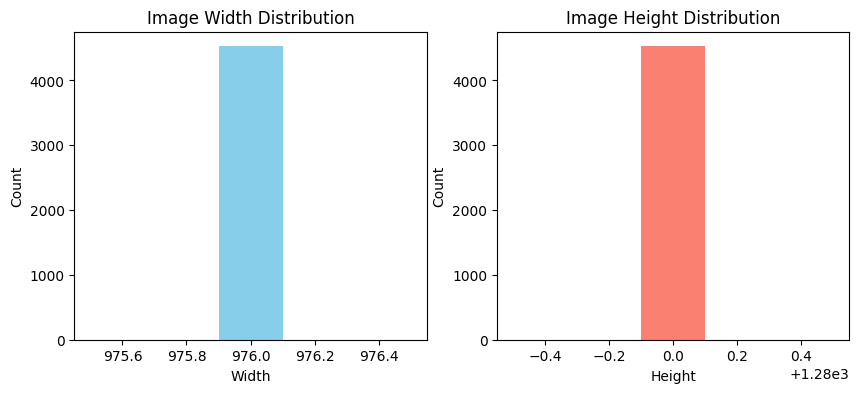

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(widths, bins=5, color='skyblue')
plt.title('Image Width Distribution')
plt.xlabel('Width'); plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(heights, bins=5, color='salmon')
plt.title('Image Height Distribution')
plt.xlabel('Height'); plt.ylabel('Count')
plt.show()

## 4️⃣ 클래스 분포 확인

In [22]:
all_labels = []
for _, target in annotations:
    all_labels.extend(target['labels'].tolist())

Class counts:
 3     514
2     240
0     180
1     172
22    143
     ... 
52     11
42     10
16      9
57      9
65      7
Name: count, Length: 73, dtype: int64


<Axes: title={'center': 'Class Distribution'}>

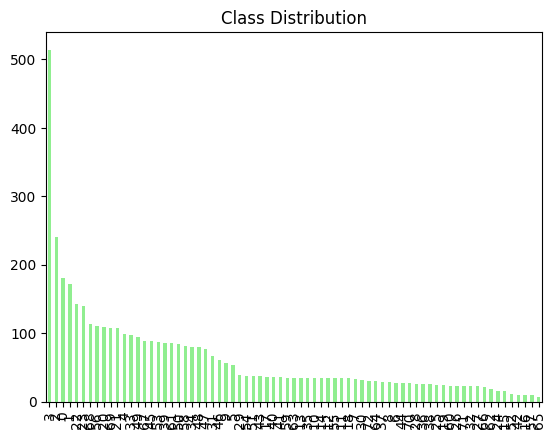

In [23]:
label_counts = pd.Series(all_labels).value_counts()
print('Class counts:\n', label_counts)
label_counts.plot(kind='bar', color='lightgreen', title='Class Distribution')

## 5️⃣ 샘플 이미지 시각화

In [24]:
import matplotlib.patches as patches
def plot_sample(dataset, idx=0):
    image, target = dataset[idx]
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.imshow(image)
    boxes = target['boxes']
    labels = target['labels']
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, str(label), color='yellow', fontsize=12, weight='bold')
    plt.show()

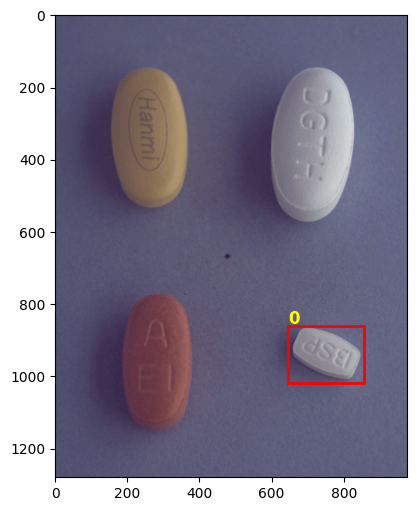

In [32]:
# 셀 단위로 샘플 시각화
plot_sample(dataset, 0)  # 첫 번째 샘플

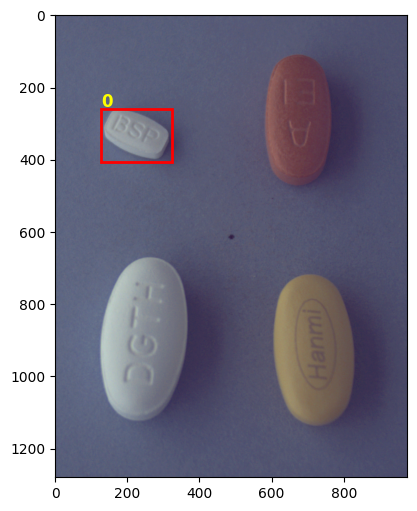

In [31]:
plot_sample(dataset, 1)  # 두 번째 샘플

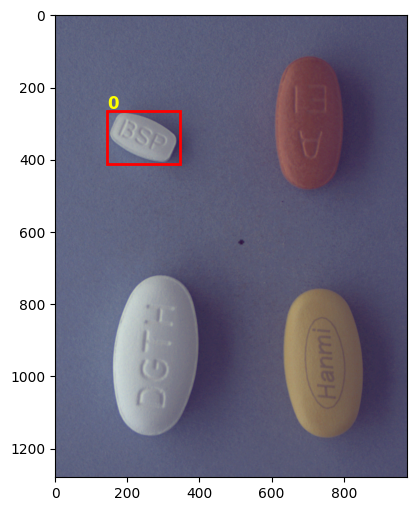

In [27]:
plot_sample(dataset, 2)  # 세 번째 샘플

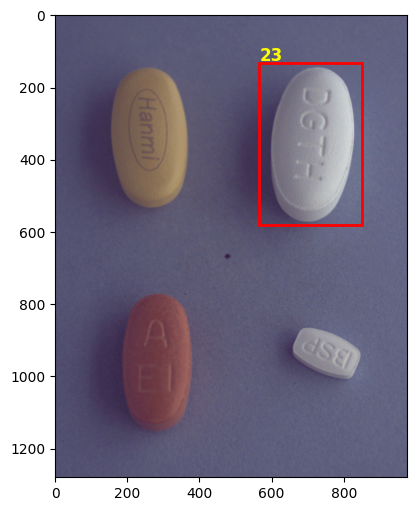

In [28]:
plot_sample(dataset, 3)  # 네 번째 샘플

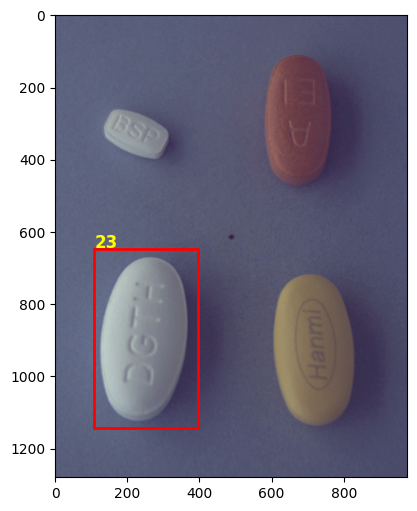

In [33]:
plot_sample(dataset, 4)  # 다섯 번째 샘플

In [34]:
# 어노테이션 정보를 yaml 파일로 저장하는 예시 코드
import yaml
yaml_data = []
for img_name, target in annotations:
    entry = {
        'image': img_name,
        'boxes': target['boxes'].tolist(),
        'labels': target['labels'].tolist()
    }
    yaml_data.append(entry)

with open('annotations_export.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(yaml_data, f, allow_unicode=True)
print('annotations_export.yaml 파일로 저장 완료')

annotations_export.yaml 파일로 저장 완료
